In [132]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
!python3 -m pip install scikit-learn numpy matplotlib pandas seaborn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


# House Price Prediction (Boston/California Housing)
- Difficulty: Beginner
- Project Purpose: Predict house prices with LinearRegression; stretch → compare OLS vs Ridge vs Lasso, plot coefficients.
- Points Examined: OLS regression, coefficient interpretation, overfitting risk.
- Doc References: Ordinary Least Squares.
- Why Useful: Foundation for regression; introduces linear models in the simplest form.

# Part 1 Data retrieval

In [228]:
import pandas as pd
import numpy as np
from sklearn import metrics, model_selection, linear_model
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline

In [23]:
!curl -L -o boston-housing-dataset.zip https://www.kaggle.com/api/v1/datasets/download/altavish/boston-housing-dataset
!unzip boston-housing-dataset.zip -d ./boston_housing

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11983  100 11983    0     0  13486      0 --:--:-- --:--:-- --:--:--     0
Archive:  boston-housing-dataset.zip
  inflating: ./boston_housing/HousingData.csv  


In [229]:
data = pd.read_csv("boston_housing/HousingData.csv")

# Part 2 Hypothesis

Following hypothesis about the data, which will be examined during the notebook.
1. Factors are linear related to house price: Will do linear regression and plot to see if the relationship fits a linear line
2. Factors do not have multiplicative effect among each other (i.e. they are separate factors): Will verify this by also doing polynomial regression and claim there's no big increase
3. Different factors have different effect on the house price, and ridge may able to smooth coefficients somehow and lasso may able to select coefficient based on different strength of alpha.
4. There might be correlated factor, can plot correlation matrix + see if ridge help this case (i.e. balance correlated factors while OLS may tend to leave one larger than the other one.)

# Part 3 Data Cleaning

In [230]:
## Checking missing values
print(data.isnull().sum(axis=0))
print(data.shape)

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64
(506, 14)


In [231]:
data_without_NA = data.dropna(how='any')
data_without_NA.shape
# here we still seem be have bunch of rows left, will keep going from here.
# More thinking, for missing values, maybe we can find if there are any correlated feature and use those feature to predict the value of missing value?

(394, 14)

In [232]:
# Standardise value as we will be using L1, L2 regression
X_without_NA = data_without_NA.drop('MEDV', axis=1)
y = data_without_NA['MEDV']
scaler = sk.preprocessing.StandardScaler(copy=False)
scaler.fit(X_without_NA)
X_scaled = scaler.transform(X_without_NA)

In [201]:
# At this stage, we have not null values which are scaled, the next step would train test split etc

# Part 4 Train Test Split

In [202]:
# feature = scaler.get_feature_names_out()
# X_scaled
# y

In [203]:
# Here we choose the magic number of 20% for train test split :)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y, test_size=0.2)

# Model Training - OLS, L1, L2 loss

In [204]:
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)

lasso = linear_model.LassoCV()
lasso.fit(X_train, y_train)

ridge = linear_model.RidgeCV()
ridge.fit(X_train, y_train)

RidgeCV()

In [205]:
# Validate the result
print("Result for Linear Regression", metrics.r2_score(y_test, ols.predict(X_test)))
print("Result for Ridge Regression", metrics.r2_score(y_test, ridge.predict(X_test)))
print("Result for Lasso Regression", metrics.r2_score(y_test, lasso.predict(X_test)))

Result for Linear Regression 0.7000731561309597
Result for Ridge Regression 0.6898910285275487
Result for Lasso Regression 0.6953659970665828


In [143]:
# We can see that they have almost identical performance, also the r2 with 0.7 is pretty good result so far, OLS seems a little bit lower than the other two, but that range of vary is negligible

In [144]:
models = {
    "Linear": ols,
    "Ridge": ridge,
    "Lasso": lasso
}

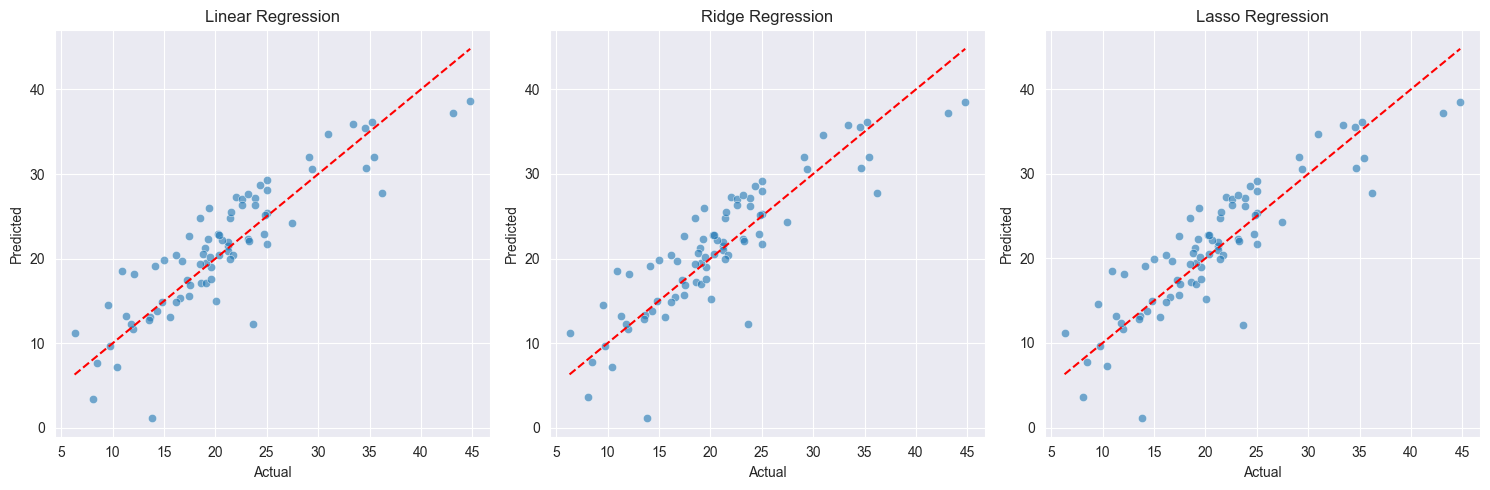

In [145]:
models = {
    "Linear": ols,
    "Ridge": ridge,
    "Lasso": lasso
}

plt.figure(figsize=(15, 5))

for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test)

    plt.subplot(1, 3, i)  # 1 row, 3 columns
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    sns.lineplot(x=[y_test.min(), y_test.max()],
                 y=[y_test.min(), y_test.max()],
                 color="red", linestyle="--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name} Regression")

plt.tight_layout()
plt.show()

## Hypothesis 1
Based on both R2 and The plot, we can say that linear regression fit the model pretty well, and here we can answer Q1:
-  Factors are linear related to house price => yes


# Doing Polynomial Regression

In [146]:
# As the linear regression is doing pretty well, based on hypothesis that there are no multiplicative effects on data, when we do multinomial regression, the coefficient for multiplied factors should be small compared to others.
poly_ols = Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=True)), ('ols', linear_model.LinearRegression())])
poly_lasso = Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=True)),('lasso', linear_model.LassoCV())])
poly_ridge = Pipeline([('poly', PolynomialFeatures(degree=2, interaction_only=True)), ('ridge', linear_model.RidgeCV())])
poly_ols.fit(X_train, y_train)
poly_lasso.fit(X_train, y_train)
poly_ridge.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(interaction_only=True)),
                ('ridge', RidgeCV())])

In [147]:
print("Result for Poly Linear Regression", metrics.r2_score(y_test, poly_ols.predict(X_test)))
print("Result for Poly Ridge Regression", metrics.r2_score(y_test, poly_ridge.predict(X_test)))
print("Result for Poly Lasso Regression", metrics.r2_score(y_test, poly_lasso.predict(X_test)))

Result for Poly Linear Regression 0.8040514120805404
Result for Poly Ridge Regression 0.87008463544358
Result for Poly Lasso Regression 0.888171095367638


## Hypothesis 2
The result here is anti our original hypothesis, as we do see big increase in all three regression, with Lasso and ridge standout the most
So at here we say that: Hypothesis 2, factors do not have multiplicative effect is false. In fact, the number that says Poly linear is bit lower than poly ridge/lasso suggest that some combination of factors have stronger implication on house price than factors themselves. But also, some multiplicative factors are not making any sense, that's why OLS is getting dragged a bit down as it is a bit overfitting to the original data. Also tried degree=3 polynomial, but the result dropped, which means that only some factor in degree 2 take effects.

# Factors' coefficient Evaluation

In [154]:
# We start by printing the coefficient of different factor without polynomial regression
feature = scaler.get_feature_names_out()
ols_coef = ols.coef_
lasso_coef = lasso.coef_
ridge_coef = ridge.coef_

In [155]:
ols_coef

array([-0.92726103,  1.17519234,  0.30268786,  0.72217315, -2.25194934,
        2.82984228, -0.03573008, -2.97491761,  2.88690297, -2.48785717,
       -2.17868851,  0.75954876, -3.42797434])

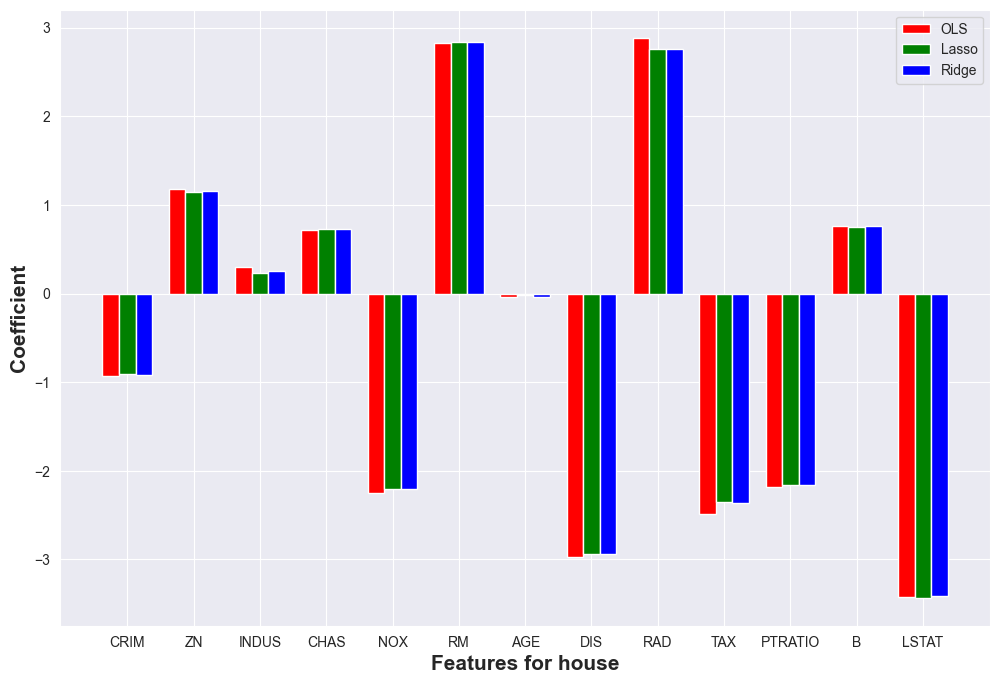

In [156]:
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))
ols_x = np.arange(len(ols_coef))
lasso_x = [x + barWidth for x in ols_x]
ridge_x = [x + barWidth for x in lasso_x]

plt.bar(ols_x, ols_coef, width=barWidth, color="r", label="OLS")
plt.bar(lasso_x, lasso_coef, width=barWidth, color="g", label="Lasso")
plt.bar(ridge_x, ridge_coef, width=barWidth, color="b", label="Ridge")
plt.xlabel('Features for house', fontweight ='bold', fontsize = 15)
plt.ylabel('Coefficient', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(ols_coef))],
        feature)
plt.legend()
plt.show()

From here we have few observations:
1. INDUS: proportion of non-retail business acres have almost nothing to do with house price, while OLS/Ridge leaves a small value for that, Lasso get rid of it completely
2. AGE is also almost irrelevant to house prices.
3. CRIM, CHAS, B have relation with house prices, but are very limited compare to other factors.
4. LSTAT and DIS have strong negative relationship with house price.
5. RM and RAD have strong implication to house prices
6. All factors here seems reasonable respect to their coefficients
7. We also see that OLS tend to have larger coefficient on both direction while ridge is relatively smaller. Lasso also does its job but sometime higer than ols and sometime lower, as its doing feature picking.

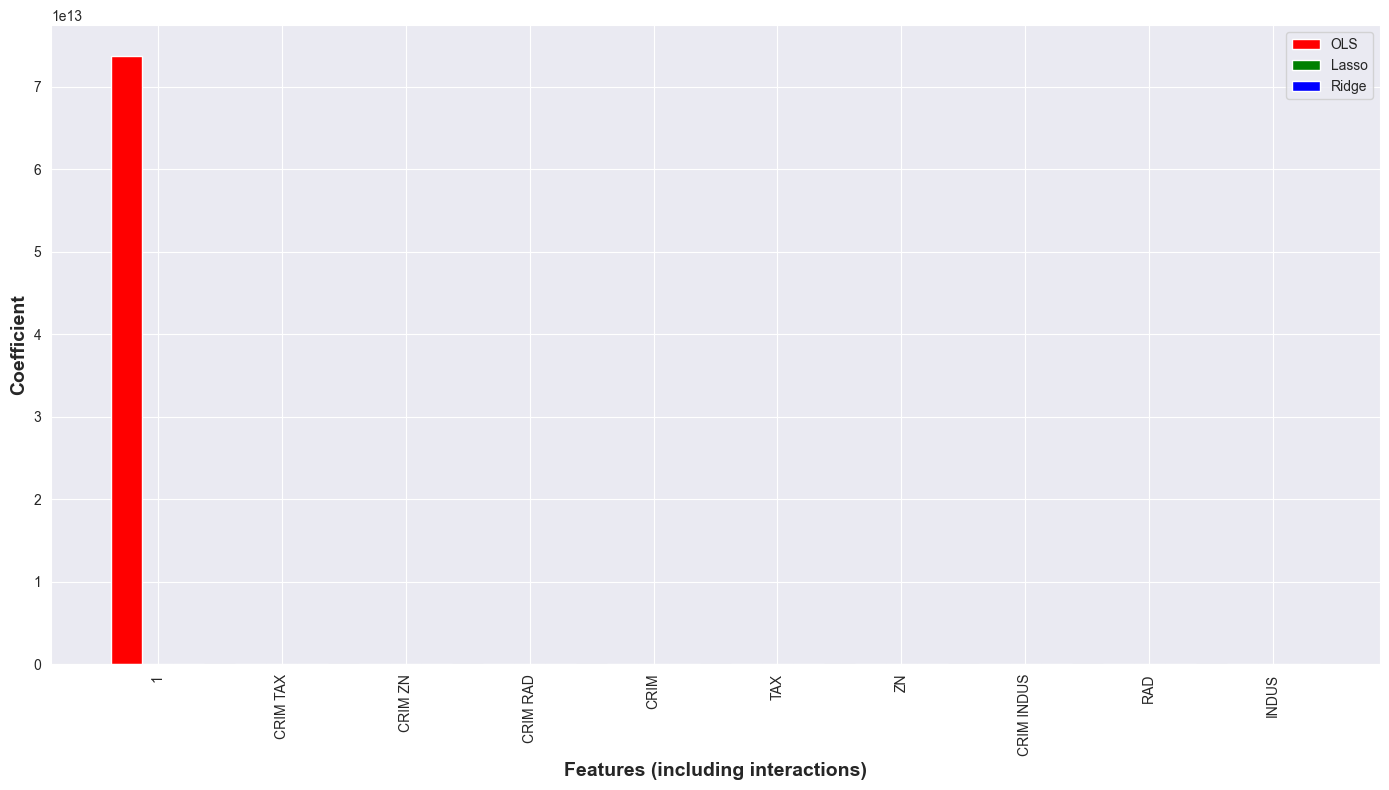

In [157]:
# Now we plot the factor multiplicative
# Step 1: get poly feature names
poly = poly_ols.named_steps['poly']
feature_names = poly.get_feature_names_out(feature)   # use your scaler's feature names here

# Step 2: get coefficients
ols_coef = poly_ols.named_steps['ols'].coef_
lasso_coef = poly_lasso.named_steps['lasso'].coef_
ridge_coef = poly_ridge.named_steps['ridge'].coef_

# Step 3: build dataframe and sort
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "OLS": ols_coef,
    "Lasso": lasso_coef,
    "Ridge": ridge_coef
})

coef_df = coef_df.reindex(coef_df["OLS"].abs().sort_values(ascending=False).index)

coef_df = coef_df.head(10)

# Step 4: plot grouped bar chart
barWidth = 0.25
fig, ax = plt.subplots(figsize=(14, 8))

indices = np.arange(len(coef_df))
lasso_x = indices + barWidth
ridge_x = indices + 2*barWidth

ax.bar(indices, coef_df["OLS"], width=barWidth, color="r", label="OLS")
ax.bar(lasso_x, coef_df["Lasso"], width=barWidth, color="g", label="Lasso")
ax.bar(ridge_x, coef_df["Ridge"], width=barWidth, color="b", label="Ridge")

ax.set_xlabel("Features (including interactions)", fontweight="bold", fontsize=14)
ax.set_ylabel("Coefficient", fontweight="bold", fontsize=14)
ax.set_xticks(indices + barWidth)
ax.set_xticklabels(coef_df["Feature"], rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

In [158]:
# We see that OLS factors are way to large compare to others, this might because when factors which are rescaled multiplied to each other, they are much smaller and require large coefficient ot bring them back, this also seems that OLS is trying ot use CRIM/TAX to clean CRIM/RAD. Also an interesting finding is that TAX/RAD get reversed sign coefficient, this is because CRIM have negative coefficient when degree = 1.

# Coefficient of OLS explodes, and we see some factors along still stand out like tax, ZN etc...

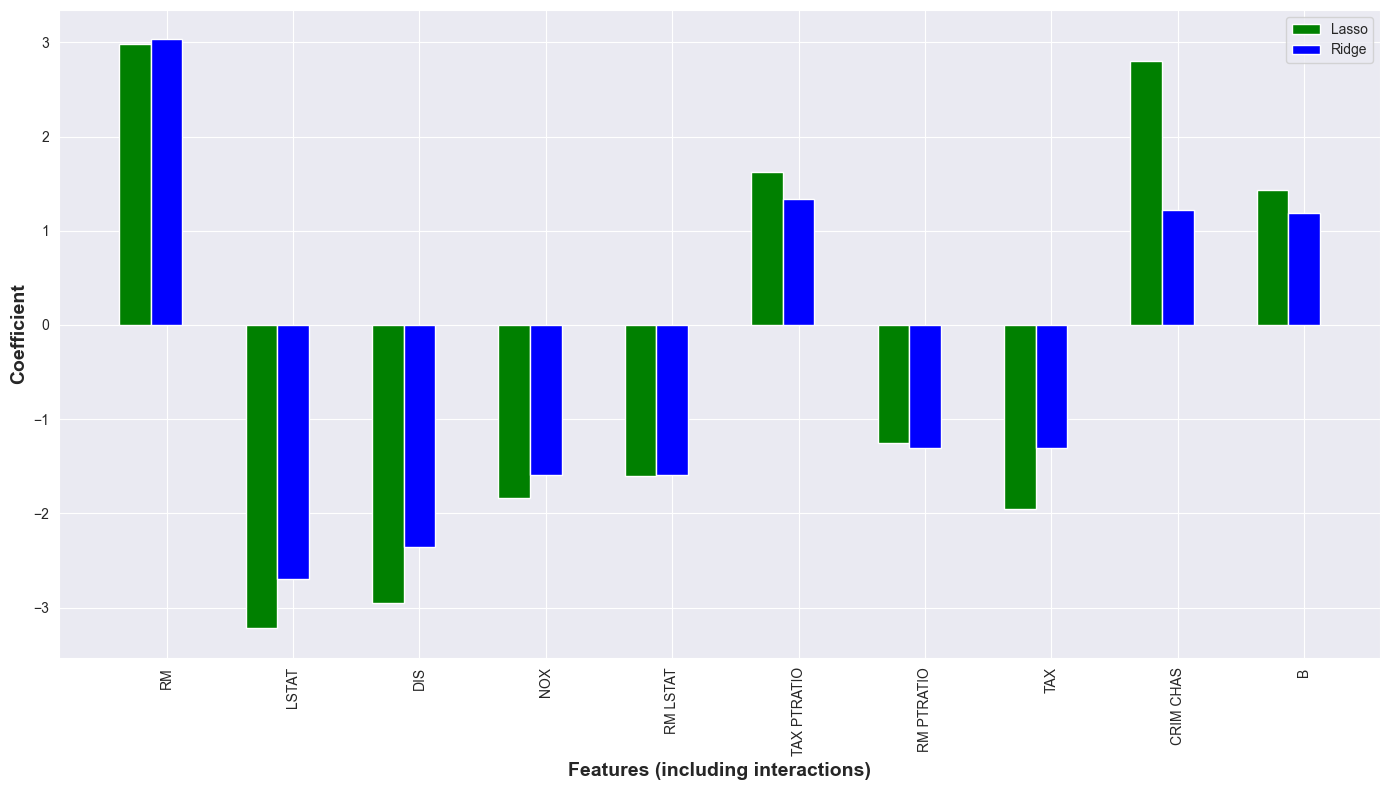

In [159]:
# Print the coefficient without OLS for better bar visibility
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "OLS": ols_coef,
    "Lasso": lasso_coef,
    "Ridge": ridge_coef
})
coef_df = coef_df.reindex(coef_df["Ridge"].abs().sort_values(ascending=False).index)
coef_df = coef_df.head(10)
barWidth = 0.25
fig, ax = plt.subplots(figsize=(14, 8))
lasso_x = np.arange(len(coef_df))
ridge_x = lasso_x + barWidth
ax.bar(lasso_x, coef_df["Lasso"], width=barWidth, color="g", label="Lasso")
ax.bar(ridge_x, coef_df["Ridge"], width=barWidth, color="b", label="Ridge")
ax.set_xlabel("Features (including interactions)", fontweight="bold", fontsize=14)
ax.set_ylabel("Coefficient", fontweight="bold", fontsize=14)
ax.set_xticks(lasso_x + barWidth)
ax.set_xticklabels(coef_df["Feature"], rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

Interesting, we see that top feature stands out here is RM and LSTAT, which is same as single degree regression, this may suggest another factor here, the reason that polynomial performing better is not because there are multiplicative effect on factors, but because some good factors multiply other irrelevant factors making those factors relevant (i.e. giving its own information to those factors), which eliminate the noise effect of irrelevant factors. This suggests a further step, lets try to only train the model with top features, namely:
- RM
- LSTAT
- DIS
- TAX
- PTRATIO
- NOX
- CRIM
- CHAS

In [163]:
wanted_features = ['RM', 'LSTAT', 'DIS', 'TAX', 'PTRATIO', 'NOX', 'CRIM', 'CHAS']
feature_names_index = [list(feature).index(f) for f in wanted_features]
X_train_feature_select, X_test_feature_select = X_train[:, feature_names_index], X_test[:, feature_names_index]
# Validate the result
ols_fs = linear_model.LinearRegression()
ols_fs.fit(X_train_feature_select, y_train)

lasso_fs = linear_model.LassoCV()
lasso_fs.fit(X_train_feature_select, y_train)

ridge_fs = linear_model.RidgeCV()
ridge_fs.fit(X_train_feature_select, y_train)
print("Result for Linear Regression", metrics.r2_score(y_test, ols_fs.predict(X_test_feature_select)))
print("Result for Ridge Regression", metrics.r2_score(y_test, ridge_fs.predict(X_test_feature_select)))
print("Result for Lasso Regression", metrics.r2_score(y_test, lasso_fs.predict(X_test_feature_select)))

# We see that the result is getting worse, meaning the rest of factors, even not contributing much, is still relevant factors to the prediction model
# QQ again, why polynomial behave better? Need GPT's input here

Result for Linear Regression 0.7144956134527307
Result for Ridge Regression 0.7214841716441298
Result for Lasso Regression 0.7155174678165519


# Hypothesis 4 Factors might be correlated

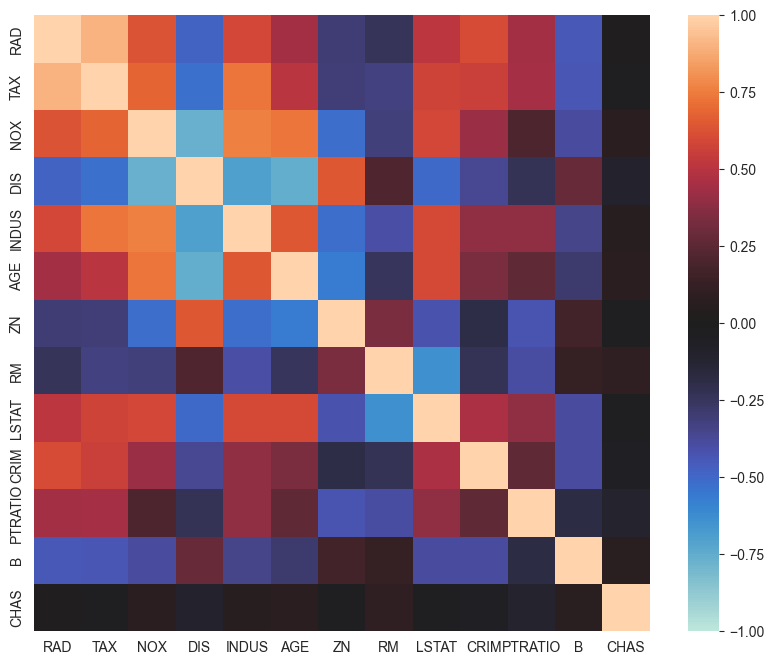

In [170]:
corr = X_without_NA.corr()

# For each feature, find the largest absolute correlation with any other feature (ignore self)
max_corr = corr.apply(lambda row: row.drop(row.name).abs().max(), axis=1)

# Reorder correlation matrix by this maximum correlation (descending)
order = max_corr.sort_values(ascending=False).index
corr_sorted = corr.loc[order, order]

# Plot
plt.figure(figsize=(10,8))
sns.heatmap(
    corr_sorted,
    vmin=-1, vmax=1, center=0,
    square=True
)
plt.show()

In [ ]:
# We see that features do have strong correlation against each other either positive or negative. This suggest that if we do PCA analysis that might be better?
# Also, as there are correlated feature, that explains why ridge would be good here as it avoids factor expand for one of the feature

# Feedback

🔍 Review & Feedback on Task 1: House Price Prediction
✅ Strengths

Clear project framing: Started with purpose, points examined, references, and usefulness → good reproducibility.

Hypotheses stated upfront: Explicit assumptions about linearity, multiplicative effects, coefficient shrinkage, and correlations.

Model coverage: Went beyond OLS → tried Ridge, Lasso, and polynomial interactions.

Visual exploration: Included correlation heatmaps, coefficient plots, and residual analysis.

Feature selection experiment: Trained with interpretable subset (RM, LSTAT, etc.), showing awareness of model simplicity.

⚠️ Areas to Improve
1. Dataset Choice

Currently using Boston Housing (deprecated for ethical concerns).

Prefer California Housing (built into scikit-learn).

2. Train/Test Split Reproducibility

Add a fixed random state to train_test_split so results are consistent each run.

3. Scaling with Ridge/Lasso

Ridge and Lasso need scaling for fair coefficient shrinkage.

Wrap them in a pipeline with StandardScaler (for polynomial)

4. Metrics & Verification

Add RMSE for interpretability (in $1000’s).

Compare against a baseline model (predict mean of y_train).

Display results in a DataFrame table for easier comparison.

5. Polynomial Interactions

Good use of interactions, but validate with cross-validation to check overfitting.

Compare R² on train vs test for degree=2 vs degree=3.

6. Correlation Analysis

Heatmap is helpful, but supplement with a Top-N correlation table.

Example: highlight that TAX ↔ RAD has a strong positive correlation.

Makes the relationships easier to see without scanning the heatmap.

7. Interpretation Depth

Expand commentary alongside results:

Which features dominate OLS vs Ridge vs Lasso?

Where does Lasso set coefficients to zero?

Does Ridge balance correlated factors as hypothesized?

🚀 Suggested Next Steps

Add cross-validation scores for OLS, Ridge, and Lasso.

Plot learning curves (train/test error vs sample size) to discuss bias/variance.

Plot residuals vs key features (e.g., RM, LSTAT) to check linearity assumption.

Show only Top-N coefficients (by absolute value) in bar plots.

Always include a baseline model to benchmark results.

# Why polynomials improve performance even if main effects dominate

Non-linear corrections:
Even if the main predictors (RM, LSTAT, etc.) remain dominant, adding polynomial terms gives the model more “flexibility” to capture subtle curvature.

Example: The relationship between LSTAT (% lower status) and MEDV (price) is not perfectly linear; prices drop faster at higher LSTAT. A quadratic term (LSTAT²) helps model that curve.

Similarly, RM (rooms) has a diminishing returns effect — the first extra room matters a lot, but the 10th doesn’t add as much. That’s a curved relationship too.

Interaction corrections:
Even if interactions aren’t the strongest predictors, they can still slightly improve fit. For instance, NOX * DIS might capture how pollution + distance together affect house prices.

Regularization suppresses weak polynomials:
Ridge shrinks and Lasso zeroes out many weak polynomial terms, so the strongest signals you see in the coefficient plot are still the original features.
But the model may still be benefiting from a handful of non-linear tweaks that don’t show up in the top 10.

In [172]:
# Build DataFrame of coefficients
coef_df_full = pd.DataFrame({
    "Feature": feature_names,
    "OLS": ols_coef,
    "Lasso": lasso_coef,
    "Ridge": ridge_coef
})

# Focus on Ridge for stability
coef_df_full["AbsRidge"] = coef_df_full["Ridge"].abs()

# Function to find base features of a polynomial/interaction term
def base_features(term):
    return term.replace("^2", "").split(" ")

# Compare coefficient magnitude of poly term vs its base features
comparisons = []
for feat, coef in zip(coef_df_full["Feature"], coef_df_full["Ridge"]):
    bases = base_features(feat)
    if len(bases) > 1 or "^2" in feat:  # interaction or quadratic
        base_coefs = []
        for b in bases:
            if b in coef_df_full["Feature"].values:
                base_coefs.append(abs(
                    coef_df_full.loc[coef_df_full["Feature"] == b, "Ridge"].values[0]
                ))
        if base_coefs:  # avoid empty
            diff = abs(coef) - max(base_coefs)
            comparisons.append((feat, coef, max(base_coefs), diff))

# Make DataFrame sorted by difference
compare_df = pd.DataFrame(comparisons, columns=["PolyFeature", "Coef(Poly)", "MaxBaseCoef", "Difference"])
compare_df = compare_df.sort_values("Difference", ascending=False)

print(compare_df.head(10))


    PolyFeature  Coef(Poly)  MaxBaseCoef  Difference
2     CRIM CHAS    1.223570     1.089311    0.134260
72  TAX PTRATIO    1.340248     1.303498    0.036751
58      AGE RAD    0.886338     0.961608   -0.075269
0       CRIM ZN    0.043969     0.216961   -0.172992
1    CRIM INDUS    0.193817     0.388881   -0.195064
7      CRIM RAD   -0.655006     0.857456   -0.202450
60  AGE PTRATIO   -0.682976     0.961608   -0.278632
12     ZN INDUS   -0.098728     0.388881   -0.290153
28    INDUS RAD   -0.508627     0.857456   -0.348829
26    INDUS AGE    0.601443     0.961608   -0.360165


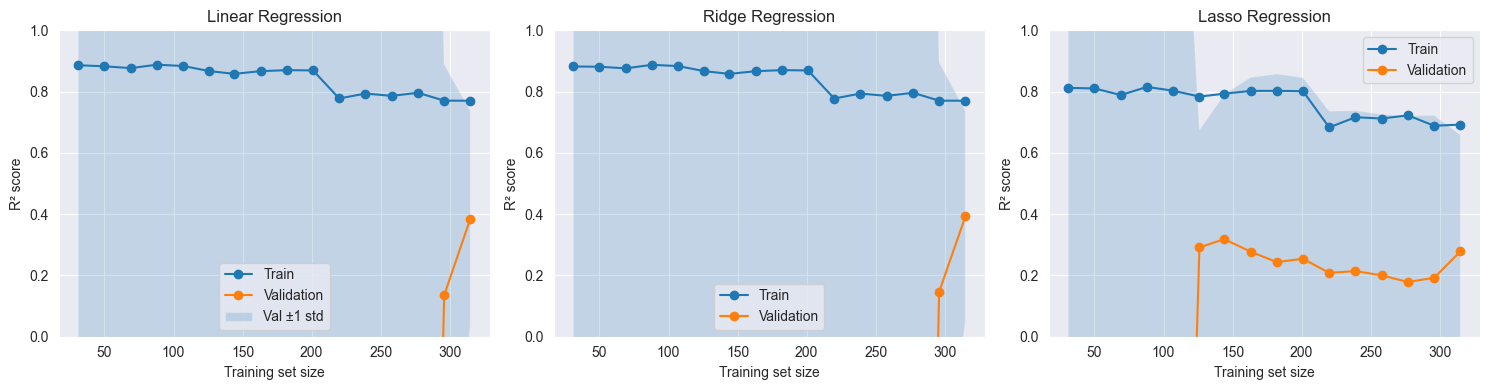

In [233]:
# Cross Validation, will check that when come to chapter 3: cross_val_score: https://scikit-learn.org/stable/modules/cross_validation.html
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import matplotlib.pyplot as plt
import numpy as np

# Replace with the feature/target you use after preprocessing
X_used = X_scaled  # or your scaled feature matrix
y_used = y             # your target

models = {
    "Linear": make_pipeline(StandardScaler(), LinearRegression()),
    "Ridge": make_pipeline(StandardScaler(), Ridge()),
    "Lasso": make_pipeline(StandardScaler(), Lasso())
}

plt.figure(figsize=(15, 4))

for i, (name, model) in enumerate(models.items(), 1):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_used, y_used,
        cv=5,
        scoring="r2",
        train_sizes=np.linspace(0.1, 1.0, 16),
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    plt.subplot(1, 3, i)
    plt.plot(train_sizes, train_mean, "o-", label="Train")
    plt.plot(train_sizes, val_mean, "o-", label="Validation")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                     alpha=0.2, label="Val ±1 std" if i==1 else None)
    plt.title(f"{name} Regression")
    plt.xlabel("Training set size")
    plt.ylabel("R² score")
    plt.ylim(0, 1)
    plt.legend()

plt.tight_layout()
plt.show()


/Users/wujizhu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e-02, tolerance: 1.199e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wujizhu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.514e-02, tolerance: 1.199e-02
  model = cd_fast.enet_coordinate_descent(
/Users/wujizhu/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

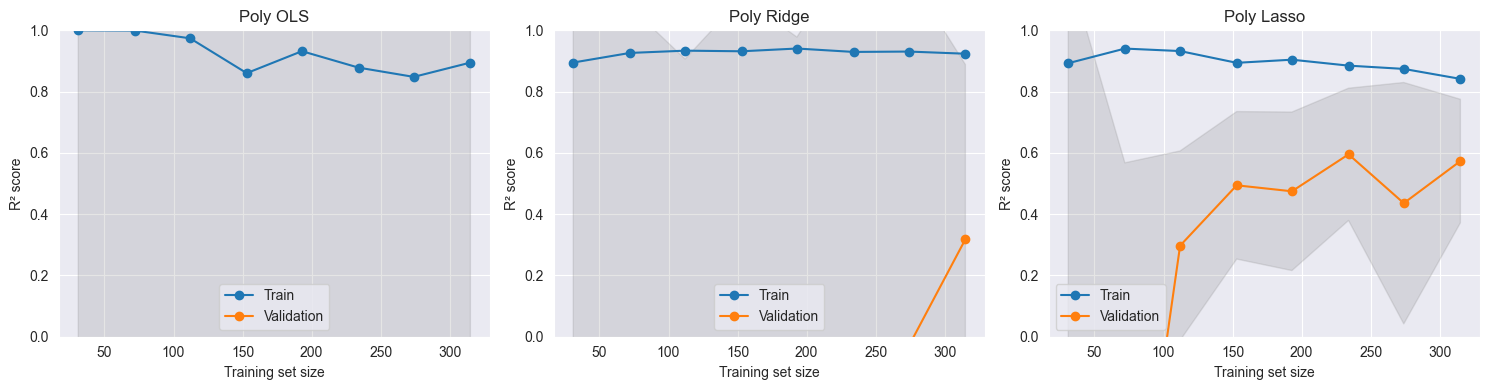

In [234]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

models = {
    "Poly OLS": poly_ols,
    "Poly Ridge": poly_ridge,
    "Poly Lasso": poly_lasso
}

plt.figure(figsize=(15, 4))

for i, (name, model) in enumerate(models.items(), 1):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_scaled, y,   # or your processed X/y
        cv=5,
        scoring="r2",
        train_sizes=np.linspace(0.1, 1.0, 8),
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    plt.subplot(1, 3, i)
    plt.plot(train_sizes, train_mean, "o-", label="Train")
    plt.plot(train_sizes, val_mean, "o-", label="Validation")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std,
                     alpha=0.2, color="gray")
    plt.title(name)
    plt.xlabel("Training set size")
    plt.ylabel("R² score")
    plt.ylim(0, 1)
    plt.legend()

plt.tight_layout()
plt.show()

The reason my repeated 80/20 train–test splits gave consistently high R² (~0.7–0.8) while the learning_curve plots sometimes sank much lower (~0.3–0.4) is due to how the splits are made. With train_test_split(0.8), I was training on a large, often “lucky” subset of ~400 rows and testing on ~100 rows that usually contained a balanced mix of normal cases and outliers, so the model generalized well. In contrast, learning_curve does repeated cross-validation at different training sizes: for each fold it samples smaller subsets (e.g. 50, 100, 350 rows), trains on those, and then evaluates on validation folds (~100 rows each). Some validation folds happen to be outlier-heavy (e.g. unusual TAX or LSTAT values), where the model performs poorly and R² can even go negative; averaging these across folds pulls the curve down. So the gap is not a contradiction — it shows that while the model often performs well, it is brittle: some test splits with outlier concentration expose weaknesses that single “lucky” splits hide.

# Residuals Check

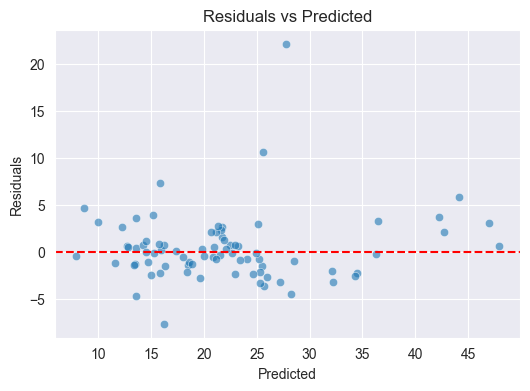

In [235]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = poly_ridge.predict(X_test)   # or poly_lasso / ols
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()


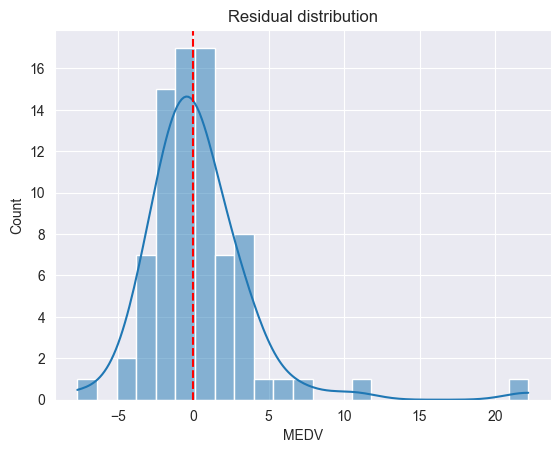

In [236]:
sns.histplot(residuals, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual distribution")
plt.show()


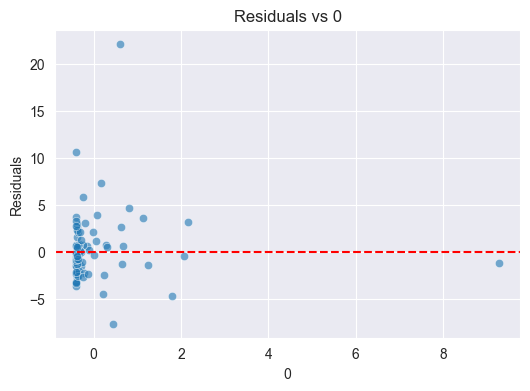

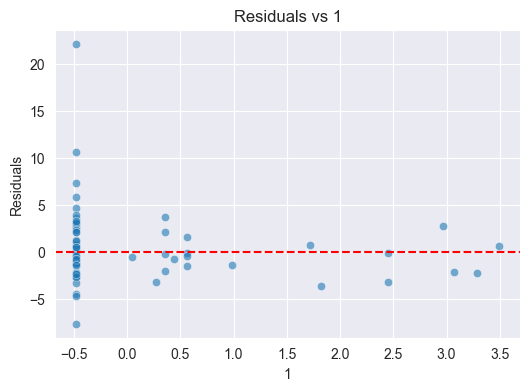

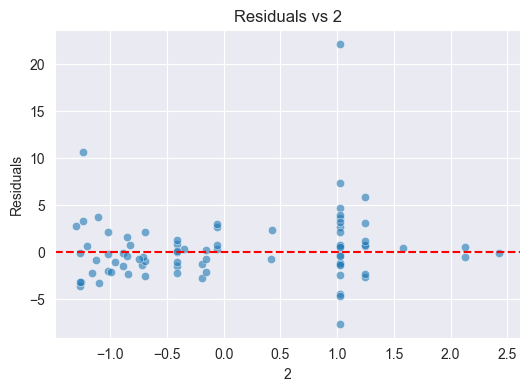

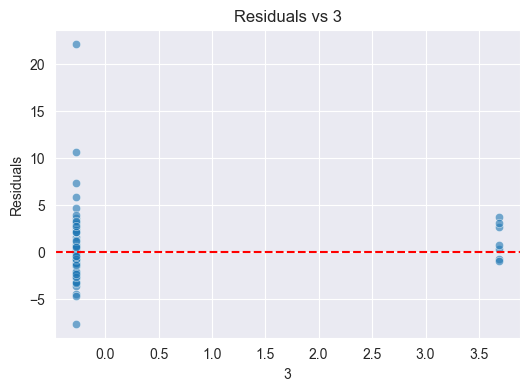

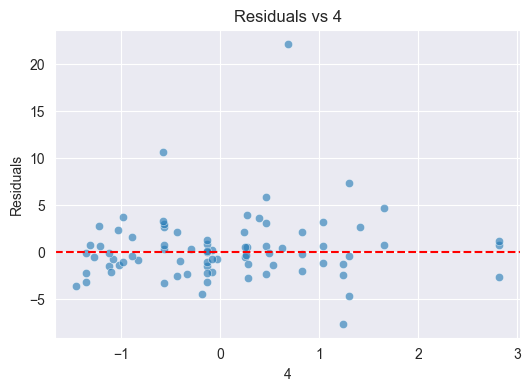

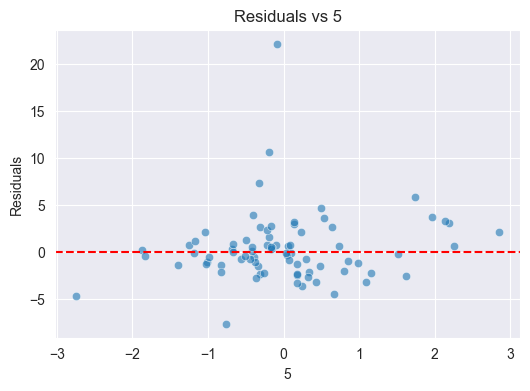

In [241]:
for feat in range(6):
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=X_test[:, feat], y=residuals, alpha=0.6)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel(feat)
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs {feat}")
    plt.show()
